# 0.0 Imports

In [7]:
import numpy as np
import pandas as pd
import psycopg2 as pg
import sweetviz as sv
import seaborn as sns
import scikitplot as skplt
import warnings
import pickle
import json
import requests
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_confusion_matrix
import xgboost as xgb

## Helper Functions

In [8]:
def pie_chart(data,att,title,legend_title):
    
    def data_detail(pct, allvalues):
        absolute = int(pct/ 100.*np.sum(allvalues['response']))
        return "{:.0f}\n({:.1f}%)".format(absolute, pct)

    wedges, texts, autotexts = plt.pie( data = data,
                                       x = 'response',
                                       autopct = lambda pct: data_detail(pct, data),
                                       textprops = dict(color="w"))
    
    plt.legend( wedges, list(data[att]),
              title = legend_title,
              loc="center left",
              bbox_to_anchor = (1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight="bold")
    plt.title(title,fontsize = 15);
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
#     sns.set()
    
jupyter_settings()


def precision_at_k(data, k):
    
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k,'precision_at_k']

def recall_at_k(data, k):

    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k,'recall_at_k']

def ranking_performance(model_name, x_validation, y_validation, yhat):

    data = x_validation.copy()
    data['response'] = y_validation.copy()

    # Propensity score
    data['score'] = yhat[:,1].tolist()

    # sort clients by propensity score
    data = data.sort_values('score',ascending=False)
    
    return pd.DataFrame(
        {'Model Name': model_name,
        'Precision at K': precision_at_k(data,k=20000),
        'Recall at K': recall_at_k(data,k=20000)},
        index=[0]
    )

def classification_performance(model_name, y_test, y_pred):
    acc = accuracy_score(y_test,y_pred)
    pre = precision_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)
    f1s = f1_score(y_test,y_pred)
    
    return pd.DataFrame({
        'Model':model_name,
        'Accuracy' : acc,
        'Precision': pre,
        'Recall': rec,
        'F1 Score': f1s}, index=[0])

def data_preparation(data,dict_preparation):
    for att in list(dict_preparation['STANDARIZATION'].keys()):
        std = dict_preparation['STANDARIZATION'][att]
        data.loc[:,att] = std.transform(data[[att]].values)

    for type_encode in list(dict_preparation['RESCALING'].keys()):
        for att in list(dict_preparation['RESCALING'][type_encode].keys()):
            std = dict_preparation['RESCALING'][type_encode][att]
            data.loc[:,att] = std.transform(data[[att]].values)

    for type_encode in list(dict_preparation['ENCONDING'].keys()):
        for att in list(dict_preparation['ENCONDING'][type_encode].keys()):
            if type_encode == 'one_hot_enconding':
                prefix = dict_preparation['ENCONDING'][type_encode][att]
                columns = dict_preparation['ENCONDING'][type_encode][att]
                data = pd.get_dummies(data, prefix = prefix,columns=[columns])
            else:
                std = dict_preparation['ENCONDING'][type_encode][att]
                data.loc[:,att] = data.loc[:,att].map(std)
                
    # fillna
    data = data.fillna(0)
                
    return data

def cross_validation(data_train,k_fold,model_name, model,verbose):

    validation_size = int(round(data_train.shape[0]*0.2,0))
    
    precision_at_k_list = []
    recall_at_k_list = []

    for k in range(0,k_fold):

        start_validation = validation_size*k
        end_validation   = validation_size*(k+1)
        range_validation = arange(start_validation,end_validation)
        range_data       = arange(0,data_train.shape[0])

        validation = data_train.iloc[ start_validation:end_validation ]
        training = data_train[ ~isin(range_data,range_validation)]

        x_training = training.drop(['id','response'],axis=1)
        y_training = training['response'].copy()

        x_validation = validation.drop(['id','response'],axis=1)
        y_validation = validation['response'].copy()

        # model fit
        m = model.fit(x_training,y_training)

        # model predict
        y_hat = m.predict_proba(x_validation)
        
        data_val = x_validation.copy()
        data_val['response'] = y_validation.copy()

        # Propensity score
        data_val['score'] = y_hat[:,1].tolist()

        # sort clients by propensity score
        data_val = data_val.sort_values('score',ascending=False)
        
        precision_at_k_list.append(precision_at_k(data_val,int(round(data_val.shape[0]*0.2,0))))
        recall_at_k_list.append(recall_at_k(data_val,int(round(data_val.shape[0]*0.2,0))))
        
        if verbose:
            print(f'k_fold: {k}')
            print('Validation Size: {} | {} - {}'.format(validation.shape[0],start_validation,end_validation))
            print('Training Size: {}'.format(training.shape[0]))
            print('Total Size: {}'.format(validation.shape[0] + training.shape[0]))
            print('Total Original Size: {}'.format(data_train.shape[0]))
            print('Precision at K: {}'.format(precision_at_k(data_val,int(round(data_val.shape[0]*0.2,0)))))
            print('Recall at K:    {}'.format(recall_at_k(data_val,int(round(data_val.shape[0]*0.2,0)))))
            print('\n')
            
    return pd.DataFrame(
                        {'Model': model_name,
                         'Precision at K': round(np.mean(precision_at_k_list),4).astype(str) + ' +/- ' + round((np.std(precision_at_k_list)),4).astype(str),
                         'Recall at K':    round(np.mean(recall_at_k_list),4).astype(str) + ' +/- ' + round((np.std(recall_at_k_list)),4).astype(str)},
                          index=[0])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.1 Load Dataset

In [9]:
# Credentials

host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd =' cdspa'

# Connection with Database
conn_string = f'host={host} port={port} dbname={database} user={username} password={pwd}'
conn = pg.connect(conn_string)

# SQL Query
query = '''
    select * 
    from pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                       LEFT JOIN pa004.insurance i ON (u.id = i.id)
'''

df = pd.read_sql(query, conn)
conn.close()
df.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [10]:
print('Rows: {}'.format(df.shape[0]))
print('Columns: {}'.format(df.shape[1]))

Rows: 381109
Columns: 14


In [11]:
df_raw = df.loc[:,~df.columns.duplicated()]
df_raw.sample(3)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
108802,106364,Male,23,8.0,152.0,1,< 1 Year,No,1,40851.0,193,0
38453,306762,Female,26,6.0,152.0,1,< 1 Year,No,1,30096.0,185,0
154423,90897,Male,45,28.0,26.0,1,1-2 Year,Yes,0,2630.0,129,0


In [12]:
print('Rows: {}'.format(df_raw.shape[0]))
print('Columns: {}'.format(df_raw.shape[1]))

Rows: 381109
Columns: 12


# 1.0 Data Description

In [13]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [14]:
print('Rows: {}'.format(df1.shape[0]))
print('Columns: {}'.format(df1.shape[1]))

Rows: 381109
Columns: 12


## 1.2 Data Types

In [15]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Change Types

In [16]:
# region_code
df1['region_code'] = df1['region_code'].astype('int64')

# policy_sales_channel 
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

In [17]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [18]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5 Data Descriptive

In [19]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [20]:
num_attributes = df1[['age','annual_premium','vintage']]
cat_attributes = df1[['gender','driving_license','vehicle_age','vehicle_damage','previously_insured','policy_sales_channel','region_code']]

### 1.5.1 Numerical atributes

In [21]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.mean)).T

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','median','std','skew','kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,38.822584,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,30564.389581,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.347397,83.671194,0.003030,-1.200688


### 1.5.2 Categorical atributes

In [22]:
for i in cat_attributes.columns:
    print(f'{i}: \nNumber of categories: {cat_attributes[i].unique().shape[0]}\nCategories: {sorted(cat_attributes[i].unique())}\n')

gender: 
Number of categories: 2
Categories: ['Female', 'Male']

driving_license: 
Number of categories: 2
Categories: [0, 1]

vehicle_age: 
Number of categories: 3
Categories: ['1-2 Year', '< 1 Year', '> 2 Years']

vehicle_damage: 
Number of categories: 2
Categories: ['No', 'Yes']

previously_insured: 
Number of categories: 2
Categories: [0, 1]

policy_sales_channel: 
Number of categories: 155
Categories: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 143, 144, 14

# 2.0 Feature Engineering

In [23]:
df2 = df1.copy()

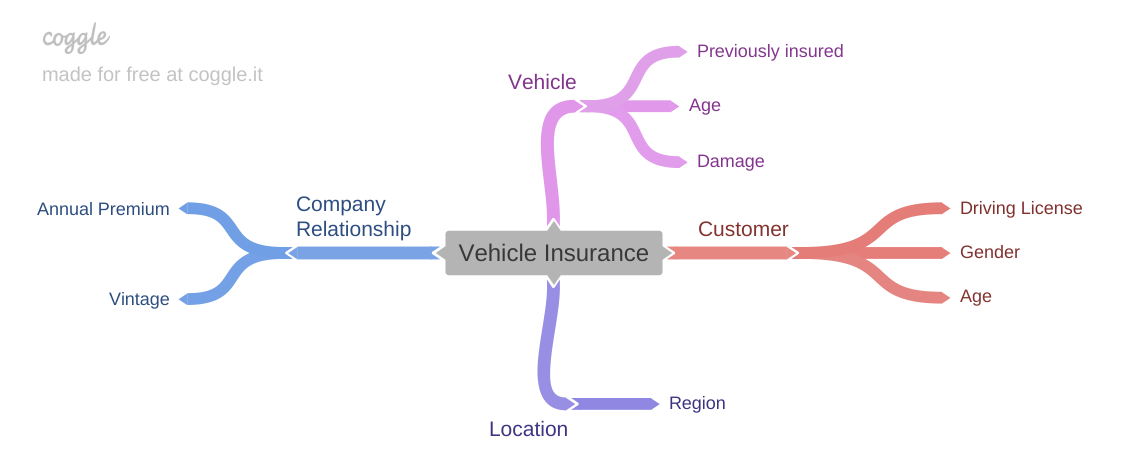

In [24]:
Image('img/Vehicle_Insurance.png')

## 2.1 Hyphotesis Mind Map

### 2.1.1 Customer's Hyphotesis

1. Customers over 40 years old are 50% more interest in vehicle insurance

### 2.1.2 Vehicle's Hyphotesis

1. Customer with a newer vehicle are 30% more interest in adquire the vericle insurance than customer with older cars

### 2.1.3 Company Relationship's Hyphotesis

1. Customer with less than 30 days in relation with the company are 40% more interest in adquire the vehicle insurance

## 2.2 Feature Criation

In [25]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15,14,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35,152,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8,160,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8,124,1,1-2 Year,Yes,0,42297.0,264,0


In [26]:
# vericle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'bellow_1_year' if x == '< 1 Year' else 
                                                     'between_1_2_year' if x == '1-2 Year' else 
                                                     'over_2_years')

In [27]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,bellow_1_year,Yes,0,23367.0,249,0
1,13,Female,41,15,14,1,between_1_2_year,No,1,31409.0,221,0
2,18,Female,25,35,152,1,bellow_1_year,No,1,46622.0,299,0
3,31,Female,26,8,160,1,bellow_1_year,No,0,2630.0,136,0
4,39,Male,45,8,124,1,between_1_2_year,Yes,0,42297.0,264,0


# 3.0 Data Filtering

In [28]:
df3 = df2.copy()

# 4.0 Exploratory Data Analysis

In [29]:
df4 = df3.copy()

In [30]:
# report = sv.analyze(df4)
# report.show_html()

## 4.1. Univariate Analysis

### 4.1.1 Numerial Variables

#### 4.1.1.1 Age

- Although people between 20 and 30 years old are not usually interest, people between 40 and 50 years old are offen intereset

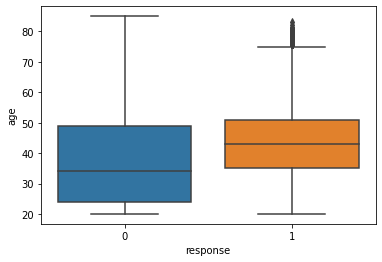

In [31]:
# 'age'
sns.boxplot(x='response',y='age',data=df4);

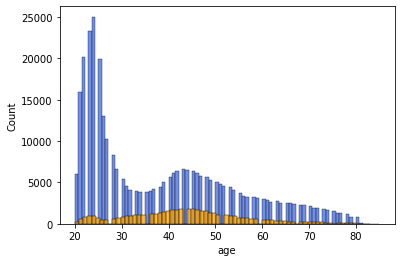

In [32]:
aux00 = df4.loc[df4['response'] == 0, 'age']
aux01 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux00,color='royalblue')
sns.histplot(aux01,color='orange');

#### 4.1.1.2 Annual Premium

- The distribuiton of annual premium are very similuar to interest and not interest people. Only the scale of this distribution are diferent

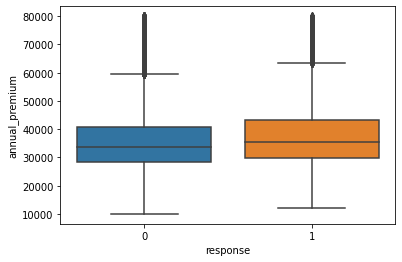

In [33]:
# 'annual_premium'
aux = df4[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000)]
sns.boxplot(x='response',y='annual_premium',data=aux);

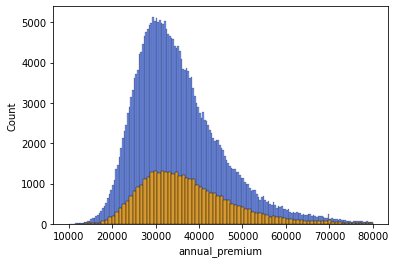

In [34]:
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
aux01 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux00,color='royalblue')
sns.histplot(aux01,color='orange');

#### 4.1.1.3 Vintage

- The vintage (days that the customer is related with the company) is uniform distribuited

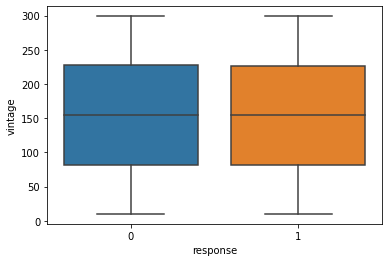

In [35]:
# 'annual_premium'
sns.boxplot(x='response',y='vintage',data=df4);

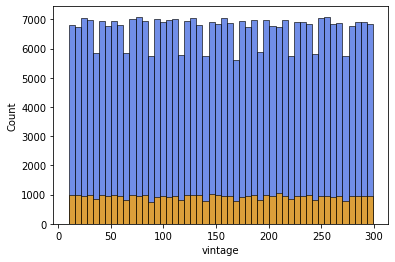

In [36]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
aux01 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux00,color='royalblue',bins=50)
sns.histplot(aux01,color='orange',bins=50);

### 4.1.2 Categorical Variables

#### 4.1.2.1 Gender

- Mens represents 54% of the elevible customer but represents 61% of whole car insurance interest

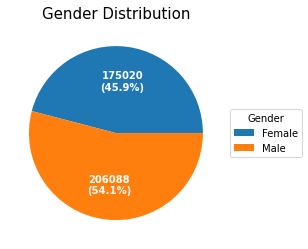

In [37]:
aux2 = pd.DataFrame(df4[['gender','response']].groupby('gender').count()).reset_index()
pie_chart(aux2,'gender',"Gender Distribution",'Gender')

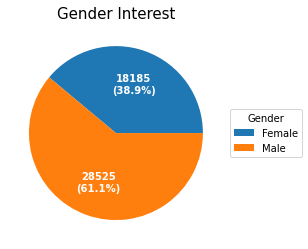

In [38]:
# pie plot
# ax = plt.figure(figsize=(15,6))
aux2 = pd.DataFrame(df4[['gender','response']].groupby('gender').sum()).reset_index()
pie_chart(aux2,'gender',"Gender Interest",'Gender')

#### 4.1.2.2 Driving License

- The majority people has driving license

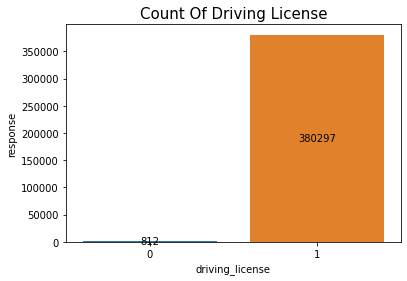

In [39]:
aux1 = df4[['driving_license','response']].groupby('driving_license').count().reset_index()
g = sns.barplot(x = 'driving_license', y = 'response', data = aux1)
g.set_title('Count Of Driving License',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'center',fontsize='medium',fmt='%.0f')

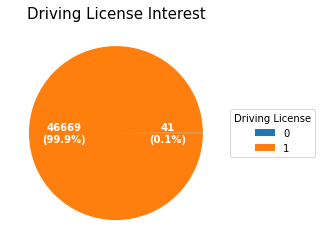

In [40]:
# pie plot
aux1 = pd.DataFrame(df4[['driving_license','response']].groupby('driving_license').sum()).reset_index()
pie_chart(aux1,'driving_license',"Driving License Interest",'Driving License')

#### 4.1.2.3 Region Code

- No region code has a significant majority of interest

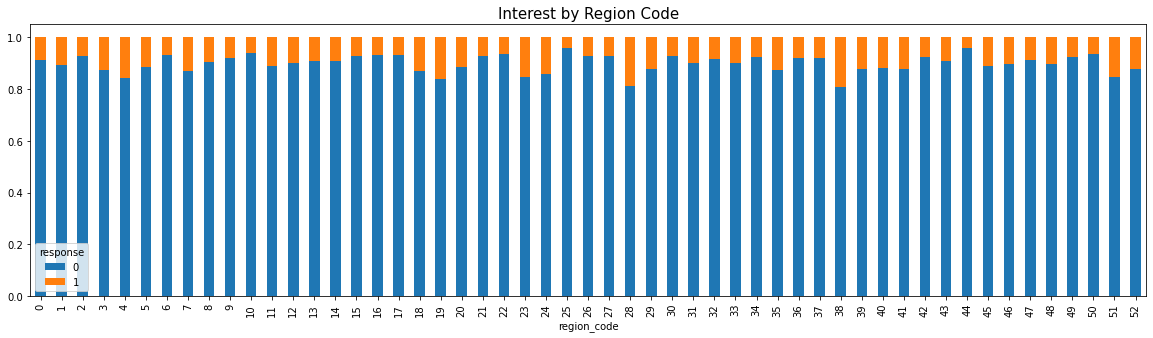

In [41]:
df_grouped = df4[["region_code", "response"]].groupby('region_code').value_counts(normalize=True).unstack('response')
g = df_grouped.plot.bar(stacked=True,figsize=(20,5));
plt.title('Interest by Region Code',fontsize=15);

#### 4.1.2.4 Previously Insured

- Although the similar number of people previously and not previously car insured, the people that haven't previoulsly insurance are the most interested

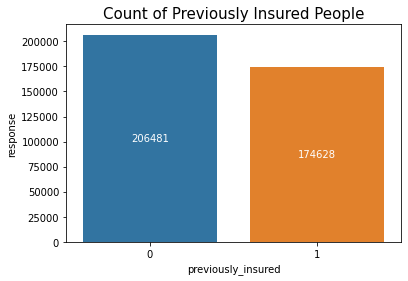

In [42]:
aux1 = df4[['previously_insured','response']].groupby('previously_insured').count().reset_index()
g = sns.barplot(x = 'previously_insured', y = 'response', data = aux1)
g.set_title('Count of Previously Insured People',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.0f')

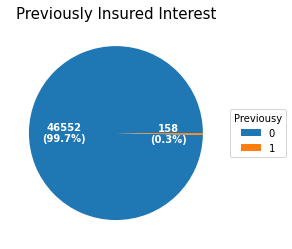

In [43]:
aux1 = pd.DataFrame(df4[['previously_insured','response']].groupby('previously_insured').sum()).reset_index()
pie_chart(aux1,'previously_insured',"Previously Insured Interest",'Previousy')

#### 4.1.2.5 Vericle Age

- The majority of people has cars bellow 2 years old, but the more interested people has cars over 2 years

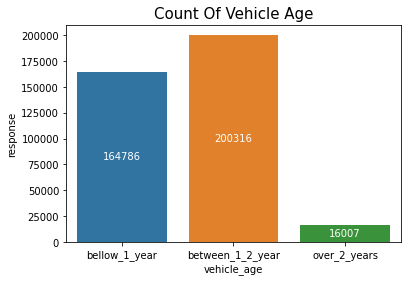

In [44]:
aux1 = df4[["vehicle_age", "response"]].groupby('vehicle_age').count().reset_index()
g = sns.barplot(x = 'vehicle_age', y = 'response', data = aux1)
g.set_title('Count Of Vehicle Age',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.0f')

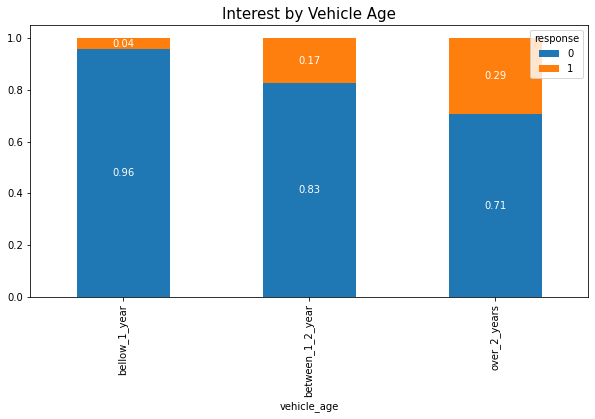

In [45]:
# 'vehicle_age'
df_grouped = df4[["vehicle_age", "response"]].groupby('vehicle_age').value_counts(normalize=True).unstack('response')
g = df_grouped.plot.bar(stacked=True,figsize=(10,5));
g.set_title('Interest by Vehicle Age',fontsize=15)

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.2f')

#### 4.1.2.6 Policy Sales Channel

- Although the quantity diference of sales channel, no channel has the majority of the interest people

In [46]:
# policy_sales_channel
aux0 = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
aux1 = aux0[aux0['response'] > 40.0]### 4.1.6 Previously Insured

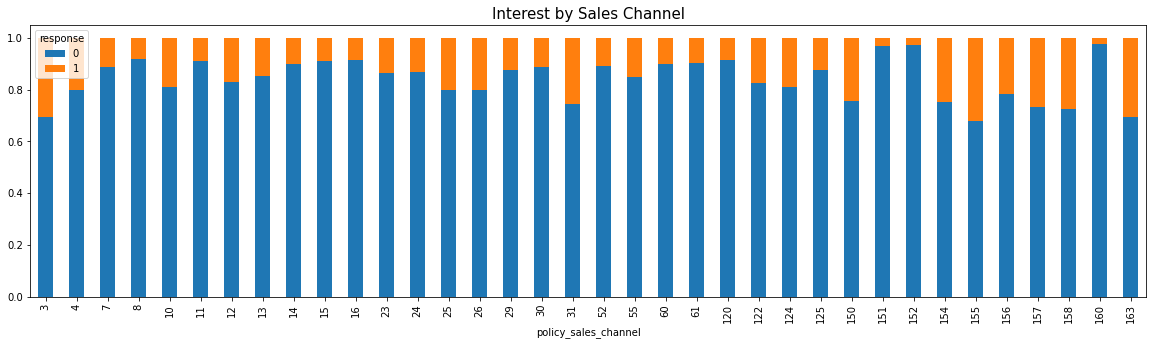

In [47]:
aux = df4[["policy_sales_channel", "response"]].groupby('policy_sales_channel').sum().reset_index()
aux = aux[aux['response'] > 40]

# 'policy_sales_channel'
aux2 = df4[df4['policy_sales_channel'].isin(aux['policy_sales_channel'])]
df_grouped = aux2[["policy_sales_channel", "response"]].groupby('policy_sales_channel').value_counts(normalize=True).unstack('response')
df_grouped.plot.bar(stacked=True,figsize=(20,5));
plt.title('Interest by Sales Channel',fontsize=15);

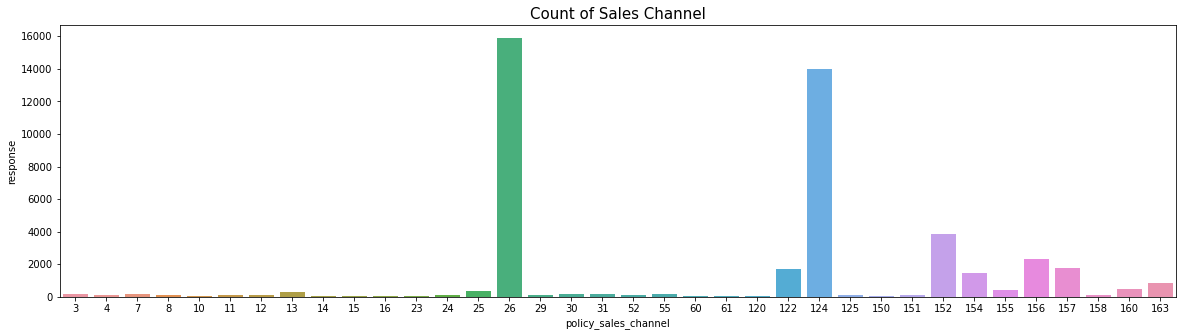

In [48]:
fig = plt.figure(figsize=(20,5))
aux = df4[["policy_sales_channel", "response"]].groupby('policy_sales_channel').sum().reset_index()
aux = aux[aux['response'] > 40]

sns.barplot(data=aux,x='policy_sales_channel',y='response');
plt.title('Count of Sales Channel',fontsize=15);

#### 4.1.2.7 Vehicle Damage

- Although tha simular number of damage and not damage vehicles, people that are more interest has a vehicle damage in the past

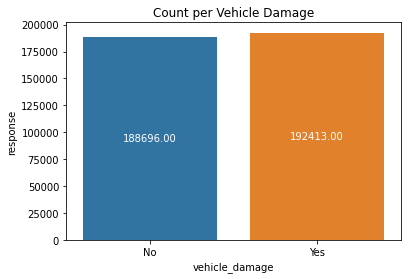

In [49]:
# 'vehicle_damage'
aux1 = df4[['vehicle_damage','response']].groupby('vehicle_damage').count().reset_index()
g = sns.barplot(x = 'vehicle_damage', y = 'response', data = aux1)
g.set_title('Count per Vehicle Damage')

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.2f')

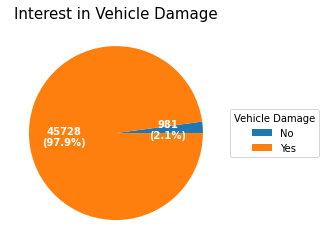

In [50]:
# pie plot
aux1 = pd.DataFrame(df4[['vehicle_damage','response']].groupby('vehicle_damage').sum()).reset_index()
pie_chart(aux1,'vehicle_damage',"Interest in Vehicle Damage",'Vehicle Damage')

## 4.2. Bivariate Analysis

### H1. Customers over 40 years old are 50% more interest in vehicle insurance

- **False**, customer over 40 years old are 48% more interest in vehicle insurance than others

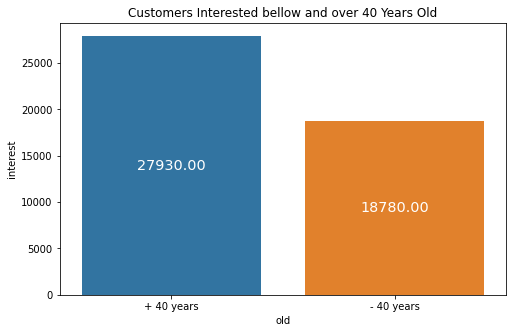

In [51]:
aux = df4[['age','response']].copy()
aux['old'] = df4['age'].apply(lambda x: '+ 40 years' if x > 40 else '- 40 years')
aux = aux[['old','response']].groupby('old').sum().reset_index().rename(columns={'response':'interest'})

fig = plt.figure(figsize=(8,5))
g = sns.barplot(x='old', y='interest', data=aux)
plt.title('Customers Interested bellow and over 40 Years Old')

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='x-large',fmt='%.2f')

In [52]:
aux['perc'] = (round(aux['interest']/aux['interest'].sum()*100,2)).astype(str) + '%'
aux['diff'] = aux['interest'].rolling(window=2).apply(lambda x: round((x.iloc[0])*100/x.iloc[1]-100,2))
aux

,old,interest,perc,diff
0,+ 40 years,27930,59.79%,NaN
1,- 40 years,18780,40.21%,48.72


### H2. Customer with a newer vehicle are 30% more interest in adquire the vericle insurance than customer with older cars

- **False**, customer with newer vehicle are 81% less interest in adquive the insurance

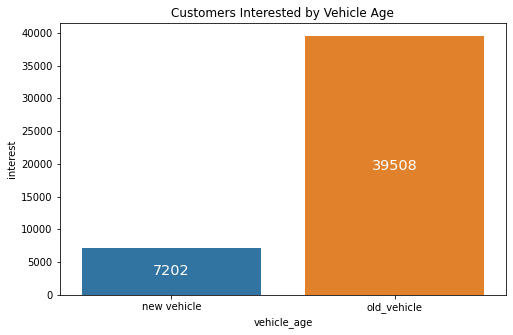

In [53]:
aux = df4[['vehicle_age','response']].copy()
aux['vehicle_age'] = aux['vehicle_age'].apply(lambda x: 'new vehicle' if x == 'bellow_1_year' else 'old_vehicle')
aux = aux.groupby('vehicle_age').sum().reset_index().rename(columns={'response':'interest'})

fig = plt.figure(figsize=(8,5))
g = sns.barplot(x='vehicle_age', y='interest', data=aux)
plt.title('Customers Interested by Vehicle Age')

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='x-large',fmt='%.0f')

In [54]:
aux['perc'] = (round(aux['interest']/aux['interest'].sum()*100,2)).astype(str) + '%'
aux['diff'] = aux['interest'].rolling(window=2).apply(lambda x: round((x.iloc[0])*100/x.iloc[1]-100,2))
aux

,vehicle_age,interest,perc,diff
0,new vehicle,7202,15.42%,NaN
1,old_vehicle,39508,84.58%,-81.77


### H3. Customer with more days in relation with the company are more interest in adquire the vehicle insurance

- **False**, as longer as the customer relationship with the company are, the lower is the interest

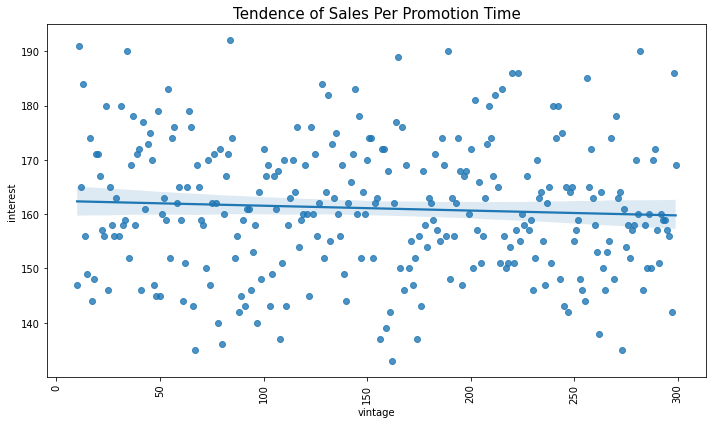

In [55]:
aux = df4[['vintage','response']].copy()
aux = aux.groupby('vintage').sum().reset_index().rename(columns={'response':'interest'})

fig = plt.figure(figsize=(10,6))
sns.regplot(x='vintage', y='interest',data=aux);
plt.xticks(rotation=90);
plt.title('Tendence of Sales Per Promotion Time',fontsize=15)
plt.tight_layout()

# 5.0 Data Preparation

In [210]:
df5 = df4.copy()

## 5.1 Split Datasets

### 5.1.1 Test and Training

In [211]:
X = df4.drop(['response'],axis=1)
y = df4['response'].copy()

X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = ms.train_test_split(X, y, test_size=0.1)

### 5.1.2 Training and Validation

In [212]:
x_train, x_validation, y_train, y_validation = ms.train_test_split(X_train_raw, Y_train_raw, test_size=0.2)

data_train = pd.concat([x_train, y_train], axis=1)

In [213]:
print('Total Dimension:            {}'.format(X.shape[0]))
print('Training Dataset Dimension: {} ({}%)'.format(X_train_raw.shape[0],round((X_train_raw.shape[0]/X.shape[0])*100,2)))
print('Test Dataset Dimension:     {} ({}%)\n'.format(X_test_raw.shape[0],round((X_test_raw.shape[0]/X.shape[0])*100,2)))

print('Training Dataset Dimension:         {}'.format(X_train_raw.shape[0]))
print('Training Model Dataset Dimension:   {} ({}%)'.format(x_train.shape[0],round((x_train.shape[0]/X_train_raw.shape[0])*100,2)))
print('Validation Model Dataset Dimension: {} ({}%)'.format(x_validation.shape[0],round((x_validation.shape[0]/X_train_raw.shape[0])*100,2)))

Total Dimension:            381109
Training Dataset Dimension: 342998 (90.0%)
Test Dataset Dimension:     38111 (10.0%)

Training Dataset Dimension:         342998
Training Model Dataset Dimension:   274398 (80.0%)
Validation Model Dataset Dimension: 68600 (20.0%)


## 5.2 Standardization

In [214]:
ss = pp.StandardScaler()

## annual_premium
data_train['annual_premium'] = ss.fit_transform(data_train[['annual_premium']].values)
pickle.dump(ss,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\annual_premium_scaler.pkl','wb'))

## 5.3 Rescaling

In [215]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

## age
data_train['age'] = mms_age.fit_transform( data_train[['age']].values )
pickle.dump(mms_age,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\age_scaler.pkl','wb'))

## vintage
data_train['vintage'] = mms_vintage.fit_transform( data_train[['vintage']].values )
pickle.dump(mms_vintage,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\vintage_scaler.pkl','wb'))

## 5.4 Encoder

### 5.4.1 One Hot Enconding

In [216]:
## vehicle_age
data_train = pd.get_dummies(data_train, prefix='vehicle_age',columns=['vehicle_age'])

### 5.4.2 Target Enconding

In [217]:
# gender 
target_encode_gender = data_train.groupby('gender')['response'].mean()
data_train.loc[:,'gender'] = data_train['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\gender_scaler.pkl','wb'))

# region_code 
target_encode_region_code = data_train.groupby('region_code')['response'].mean()
data_train.loc[:,'region_code'] = data_train['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\region_code_scaler.pkl','wb'))

# vehicle damage
target_encode_vehicle_damage = data_train.groupby('vehicle_damage')['response'].mean()
data_train.loc[:,'vehicle_damage'] = data_train['vehicle_damage'].map(target_encode_vehicle_damage)
pickle.dump(target_encode_vehicle_damage,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\vehicle_damage_scaler.pkl','wb'))

### 5.4.3 Frequency Enconding

In [218]:
## policy_sales_channel 
fe_policy_sales_channel = data_train.groupby('policy_sales_channel').size()/len(data_train)
data_train.loc[:,'policy_sales_channel'] = data_train['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\policy_sales_channel_scaler.pkl','wb'))

In [219]:
data_train.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,response,vehicle_age_bellow_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
170862,222145,0.138415,0.384615,0.070092,0.209528,1,0.005187,1,0.706000,0.958478,0,0,1,0
330270,353493,0.104277,0.169231,0.072675,0.017442,1,0.238136,0,-1.620576,0.837370,0,0,1,0
334807,9398,0.138415,0.153846,0.118115,0.353133,1,0.005187,1,0.436967,0.342561,0,1,0,0
169427,210013,0.104277,0.246154,0.061158,0.001352,1,0.238136,0,-0.305497,0.259516,1,0,0,1
243825,42708,0.138415,0.523077,0.188536,0.209528,1,0.238136,0,1.390785,0.927336,1,0,1,0


## 5.5 Validation Preparation

In [220]:
x_validation.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage
217992,216717,Male,61,48,122,1,between_1_2_year,Yes,0,2630.0,156
87658,318651,Female,32,45,152,1,bellow_1_year,No,1,35438.0,124
291398,41654,Male,40,28,52,1,between_1_2_year,Yes,0,55358.0,106
18435,147309,Male,29,41,154,1,bellow_1_year,Yes,0,2630.0,155
35600,284171,Female,21,47,160,1,bellow_1_year,Yes,0,36771.0,160


In [221]:
dict_preparation = {
    'STANDARIZATION':{
        'annual_premium':ss
    },
    'RESCALING': {
        'min_max_scaler':{
            'age':    mms_age,
            'vintage':mms_vintage
        }
    },
    'ENCONDING':{
        'one_hot_enconding':{
            'vehicle_age':'vehicle_age'
        },
        'target_enconding':{
            'gender':         target_encode_gender,
            'region_code':    target_encode_region_code,
            'vehicle_damage': target_encode_vehicle_damage
        },
        'frequency_encoding':{
            'policy_sales_channel':fe_policy_sales_channel
        }
    }
}

In [222]:
def data_preparation(data,dict_preparation):
    for att in list(dict_preparation['STANDARIZATION'].keys()):
        std = dict_preparation['STANDARIZATION'][att]
        data.loc[:,att] = std.transform(data[[att]].values)

    for type_encode in list(dict_preparation['RESCALING'].keys()):
        for att in list(dict_preparation['RESCALING'][type_encode].keys()):
            std = dict_preparation['RESCALING'][type_encode][att]
            data.loc[:,att] = std.transform(data[[att]].values)

    for type_encode in list(dict_preparation['ENCONDING'].keys()):
        for att in list(dict_preparation['ENCONDING'][type_encode].keys()):
            if type_encode == 'one_hot_enconding':
                prefix = dict_preparation['ENCONDING'][type_encode][att]
                columns = dict_preparation['ENCONDING'][type_encode][att]
                data = pd.get_dummies(data, prefix = prefix,columns=[columns])
            else:
                std = dict_preparation['ENCONDING'][type_encode][att]
                data.loc[:,att] = data.loc[:,att].map(std)
                
    # fillna
    data = data.fillna(0)
                
    return data

In [223]:
x_validation = data_preparation(x_validation,dict_preparation)

In [224]:
x_validation.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_bellow_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
217992,216717,0.138415,0.630769,0.102481,0.026086,1,0.238136,0,-1.620576,0.505190,0,1,0
87658,318651,0.104277,0.184615,0.108787,0.353133,1,0.005187,1,0.281263,0.394464,1,0,0
291398,41654,0.138415,0.307692,0.188536,0.002722,1,0.238136,0,1.436000,0.332180,0,1,0
18435,147309,0.138415,0.138462,0.118115,0.015725,1,0.238136,0,-1.620576,0.501730,1,0,0
35600,284171,0.104277,0.015385,0.086998,0.057107,1,0.238136,0,0.358535,0.519031,1,0,0


# 6.0 Feature Selection

## 6.1 Feature Importance

In [225]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = data_train.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

# Print the feature ranking
print('Feature ranking')
df = pd.DataFrame()
for i, j in zip(x_train_n.columns, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df= pd.concat([df, aux], axis=0)

df = df.sort_values('importance',ascending=False)
df

Feature ranking


,feature,importance
0,vintage,0.272344
0,annual_premium,0.242243
0,age,0.168627
0,region_code,0.104010
0,vehicle_damage,0.066537
0,policy_sales_channel,0.059619
0,previously_insured,0.058296
0,vehicle_age_bellow_1_year,0.013887
0,vehicle_age_between_1_2_year,0.006595
0,gender,0.005247


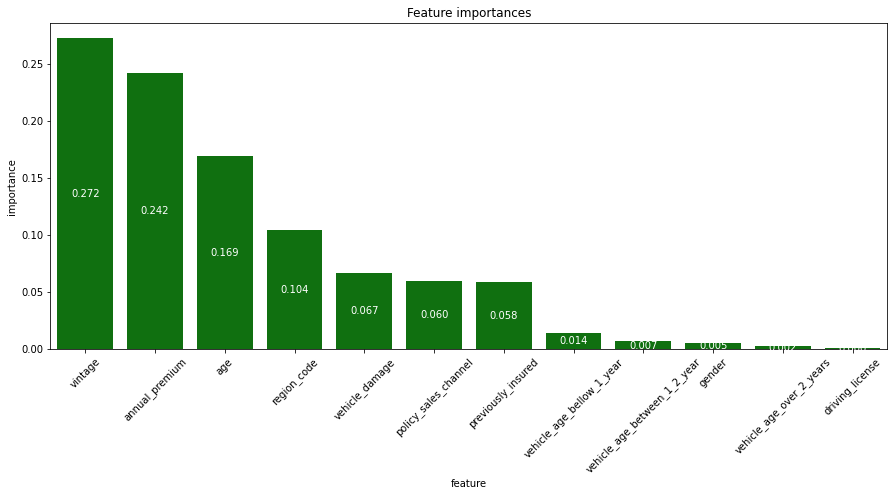

In [226]:
# plot the impurity-based feature importance of the forest

plt.figure(figsize=(15,6))
plt.title('Feature importances')
g = sns.barplot(x='feature',y='importance',data=df,color='green')
plt.xticks(rotation=45)

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.3f')

# 7.0 Machine Learning

In [227]:
cols_selected = [
                'vintage',
                'annual_premium',
                'age',
                'region_code',
                'vehicle_damage',
                'policy_sales_channel',
                'previously_insured']

x_train = data_train[cols_selected]
x_val = x_validation[cols_selected]

## 7.1 KNN

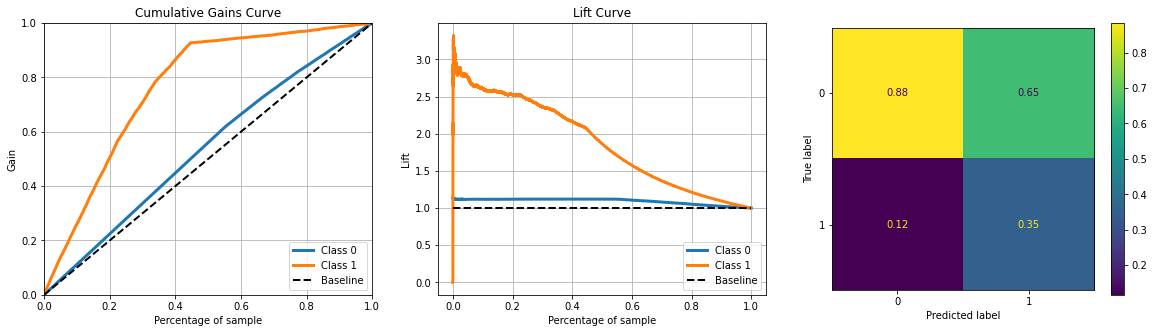

In [228]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=10)

# model training
knn_model.fit(x_train, y_train)

# ==== Model Score 
# model prediction
y_score_knn = knn_model.predict_proba(x_val)
# performance
knn_result_rank = ranking_performance('KNN', x_validation, y_validation,y_score_knn)

# ==== Model Prediction 
# model prediction
y_pred_knn = knn_model.predict(x_val)
# performance
knn_result_class = classification_performance('KNN', y_validation, y_pred_knn)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,y_score_knn,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,y_score_knn,ax=ax[1]);
plot_confusion_matrix(knn_model, x_val,y_validation,normalize='pred',ax=ax[2])  
plt.show() 

## 7.2 Logistic Regressor

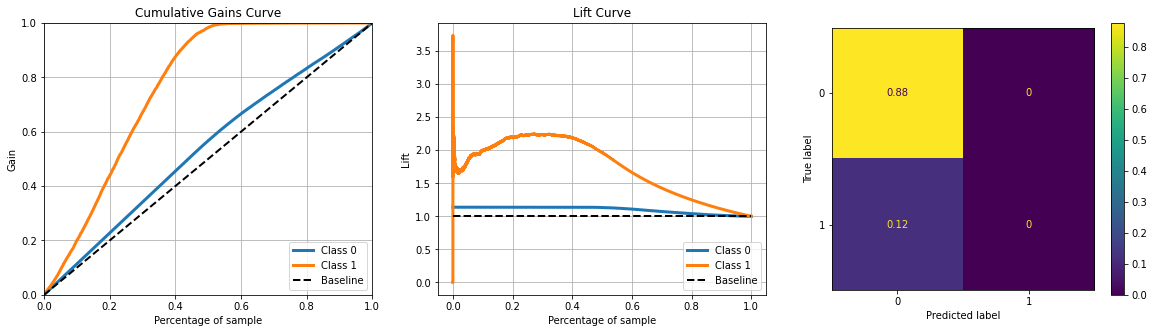

In [229]:
# model definition
lr_model = lm.LogisticRegression(random_state=42,C = 0.001)

# model training 
lr_model.fit(x_train, y_train)

# ==== Model Score 
# model prediction
y_score_lr = lr_model.predict_proba(x_val)
# performance
lr_result_rank = ranking_performance('Logistic Regression', x_validation, y_validation,y_score_lr)

# ==== Model Prediction 
# model prediction
y_pred_lr = lr_model.predict(x_val)
# performance
lr_result_class = classification_performance('Logistic Regression', y_validation, y_pred_lr)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,y_score_lr,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,y_score_lr,ax=ax[1]);
plot_confusion_matrix(lr_model, x_val,y_validation,normalize='pred',ax=ax[2])  
plt.show() 

## 7.3 Extra Trees

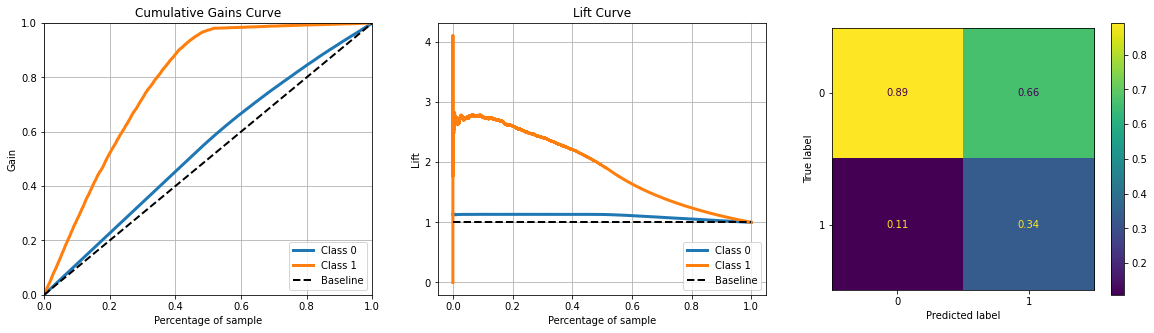

In [230]:
# model definition
et_model = en.ExtraTreesClassifier(n_estimators = 100, n_jobs=-1, random_state=42)

# model fit
et_model.fit(x_train, y_train)

# ==== Model Score 
# model prediction
y_score_et = et_model.predict_proba(x_val)
# performance
et_result_rank = ranking_performance('Extra Tree', x_validation, y_validation,y_score_et)

# ==== Model Prediction 
# model prediction
y_pred_et = et_model.predict(x_val)
# performance
et_result_class = classification_performance('Extra Trees', y_validation, y_pred_et)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,y_score_et,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,y_score_et,ax=ax[1]);
plot_confusion_matrix(et_model, x_val,y_validation,normalize='pred',ax=ax[2])  
plt.show() 

## 7.4 XGBoost

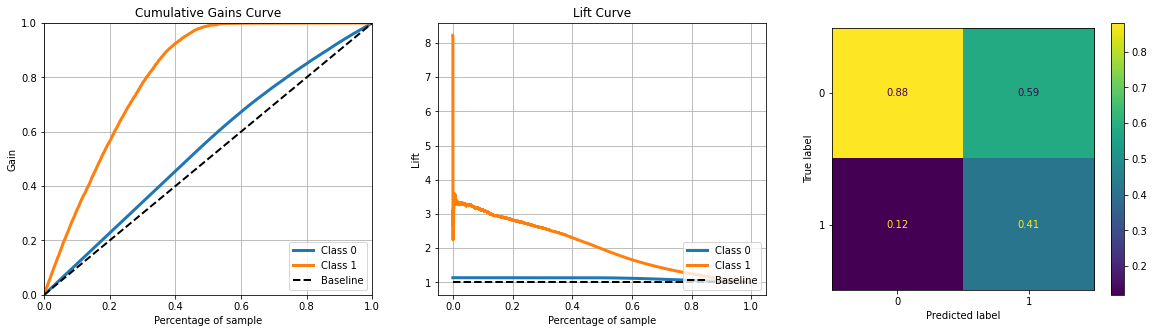

In [231]:
# model definition
xgb_model = xgb.XGBClassifier(n_estimators = 100)

# model fit
xgb_model.fit(x_train,y_train)

# ==== Model Score 
# model prediction
y_score_xgb = xgb_model.predict_proba(x_val)
# performance
xgb_result_rank = ranking_performance('XGBoost', x_validation, y_validation,y_score_xgb)

# ==== Model Prediction 
# model prediction
y_pred_xgb = xgb_model.predict(x_val)
# performance
xgb_result_class = classification_performance('XGBoost', y_validation, y_pred_xgb)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,y_score_xgb,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,y_score_xgb,ax=ax[1]);
plot_confusion_matrix(xgb_model, x_val,y_validation,normalize='pred',ax=ax[2])  
plt.show() 

## 7.5 LightGBM

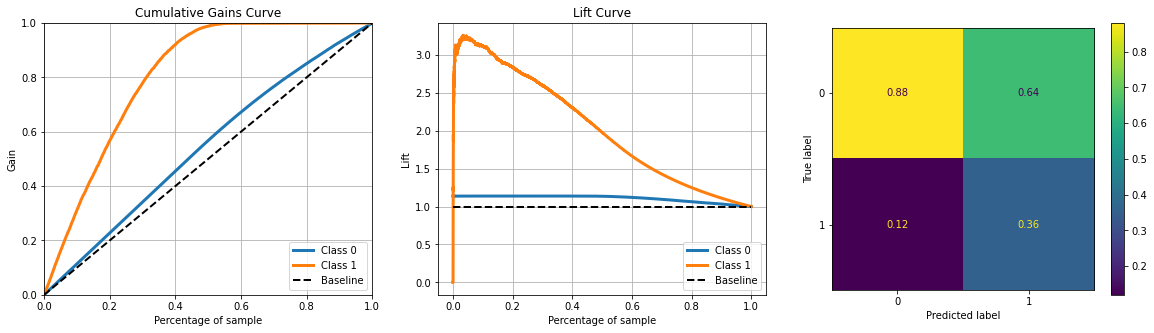

In [232]:
# model definition
lgbm_model = lgb.LGBMClassifier(n_estimators = 600)

# model fit
lgbm_model.fit(x_train,y_train)

# ==== Model Score 
# model prediction
y_score_lgb = lgbm_model.predict_proba(x_val)
# performance
lgb_result_rank = ranking_performance('LightGMB', x_validation, y_validation,y_score_lgb)

# ==== Model Prediction 
# model prediction
y_pred_lgb = lgbm_model.predict(x_val)
# performance
lgb_result_class = classification_performance('LightGMB', y_validation, y_pred_lgb)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,y_score_lgb,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,y_score_lgb,ax=ax[1]);
plot_confusion_matrix(lgbm_model, x_val,y_validation,normalize='pred',ax=ax[2])  
plt.show() 

## 7.5 Model Single Performance

In [233]:
pd.concat([knn_result_rank, lr_result_rank, et_result_rank, xgb_result_rank])

,Model Name,Precision at K,Recall at K
0,KNN,0.289536,0.694281
0,Logistic Regression,0.271586,0.651241
0,Extra Tree,0.295135,0.707709
0,XGBoost,0.317484,0.761300


In [234]:
pd.concat([knn_result_class, lr_result_class, et_result_class, xgb_result_class])

,Model,Accuracy,Precision,Recall,F1 Score
0,KNN,0.871516,0.350222,0.066299,0.111492
0,Logistic Regression,0.878411,0.000000,0.000000,0.000000
0,Extra Trees,0.860554,0.335570,0.149862,0.207194
0,XGBoost,0.877638,0.414239,0.015346,0.029595


## 7.6 Model Real Performance

In [235]:
# knn_cross = cross_validation(data_train,5,'KNN',knn_model,verbose=False)
# lr_cross = cross_validation(data_train,5,'Logistic Regression',lr_model,verbose=False)
# et_cross = cross_validation(data_train,5,'Extra Trees',et,verbose=False)
# xgb_cross = cross_validation(data_train,5,'XGBoost',xgb_model,verbose=False)

# pd.concat([knn_cross, lr_cross, et_cross, xgb_cross])

# 8.0 Hyperparameters Fine Tuning

In [205]:
# import optuna

# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators',300, 1000)
#     eta = trial.suggest_float('eta',0.01, 0.05)
#     max_depth = trial.suggest_int('max_depth', 3, 9)
#     subsample = trial.suggest_float('subsample',0.1, 0.9)
#     colsample_bytree = trial.suggest_float('colsample_bytree',0.1,0.9)
    
#     # model definition
#     xgb_model = xgb.XGBClassifier( n_estimators    = n_estimators, 
#                                   eta              = eta, 
#                                   max_depth        = max_depth, 
#                                   subsample        = subsample,
#                                   colsample_bytree = colsample_bytree
#                                  )

#     # model fit
#     xgb_model.fit(x_train,y_train)

#     # ==== Model Prediction 
#     # model prediction
#     y_pred_xgb = xgb_model.predict(x_val)
    
#     return accuracy_score(y_validation,y_pred_xgb)

# study = optuna.create_study()
# study.optimize(objective, n_trials=100)

# study.best_params

[I 2022-10-24 07:53:34,955] A new study created in memory with name: no-name-0cfd18ad-09aa-4da5-a0fa-eb18cdeb623b
[I 2022-10-24 07:55:16,964] Trial 0 finished with value: 0.878338192419825 and parameters: {'n_estimators': 565, 'eta': 0.023161485427085498, 'max_depth': 9, 'subsample': 0.7660891297229991, 'colsample_bytree': 0.7509618257028409}. Best is trial 0 with value: 0.878338192419825.
[I 2022-10-24 07:56:11,365] Trial 1 finished with value: 0.878338192419825 and parameters: {'n_estimators': 602, 'eta': 0.031434574696195615, 'max_depth': 7, 'subsample': 0.19471669529699362, 'colsample_bytree': 0.34695035530623}. Best is trial 0 with value: 0.878338192419825.
[I 2022-10-24 07:56:44,840] Trial 2 finished with value: 0.878396501457726 and parameters: {'n_estimators': 376, 'eta': 0.03523357719364894, 'max_depth': 5, 'subsample': 0.10204859571465202, 'colsample_bytree': 0.7886469635870439}. Best is trial 0 with value: 0.878338192419825.
[I 2022-10-24 07:57:37,300] Trial 3 finished with 

[I 2022-10-24 08:52:54,072] Trial 28 finished with value: 0.8775801749271137 and parameters: {'n_estimators': 686, 'eta': 0.03750625907761641, 'max_depth': 9, 'subsample': 0.46236836742214427, 'colsample_bytree': 0.6894288090160238}. Best is trial 17 with value: 0.87466472303207.
[I 2022-10-24 08:56:09,578] Trial 29 finished with value: 0.8779154518950437 and parameters: {'n_estimators': 888, 'eta': 0.020933314191427528, 'max_depth': 9, 'subsample': 0.7384563837194562, 'colsample_bytree': 0.7500992027589719}. Best is trial 17 with value: 0.87466472303207.
[I 2022-10-24 08:58:24,332] Trial 30 finished with value: 0.8771428571428571 and parameters: {'n_estimators': 947, 'eta': 0.041441564731464146, 'max_depth': 7, 'subsample': 0.2648523880014937, 'colsample_bytree': 0.5987648665171935}. Best is trial 17 with value: 0.87466472303207.
[I 2022-10-24 09:01:35,060] Trial 31 finished with value: 0.8764285714285714 and parameters: {'n_estimators': 964, 'eta': 0.04966053319172191, 'max_depth': 9

[I 2022-10-24 12:50:35,310] Trial 56 finished with value: 0.8748542274052478 and parameters: {'n_estimators': 797, 'eta': 0.04576815918406053, 'max_depth': 9, 'subsample': 0.41735084631790864, 'colsample_bytree': 0.8561789798499834}. Best is trial 17 with value: 0.87466472303207.
[I 2022-10-24 12:52:06,478] Trial 57 finished with value: 0.8779591836734694 and parameters: {'n_estimators': 767, 'eta': 0.04323277323749028, 'max_depth': 6, 'subsample': 0.4031055773770831, 'colsample_bytree': 0.8553336838705039}. Best is trial 17 with value: 0.87466472303207.
[I 2022-10-24 12:53:15,159] Trial 58 finished with value: 0.8782507288629737 and parameters: {'n_estimators': 818, 'eta': 0.045323892539483955, 'max_depth': 4, 'subsample': 0.3338414916462987, 'colsample_bytree': 0.820671313712025}. Best is trial 17 with value: 0.87466472303207.
[I 2022-10-24 12:55:56,417] Trial 59 finished with value: 0.8756122448979592 and parameters: {'n_estimators': 851, 'eta': 0.046262913616245, 'max_depth': 9, 's

[I 2022-10-24 13:52:46,661] Trial 84 finished with value: 0.8743002915451895 and parameters: {'n_estimators': 942, 'eta': 0.045005130024165944, 'max_depth': 9, 'subsample': 0.24361008625332023, 'colsample_bytree': 0.8085786631936905}. Best is trial 81 with value: 0.8734985422740524.
[I 2022-10-24 13:55:08,491] Trial 85 finished with value: 0.8741690962099126 and parameters: {'n_estimators': 939, 'eta': 0.04292436329247451, 'max_depth': 9, 'subsample': 0.2536042281995851, 'colsample_bytree': 0.8264373609305445}. Best is trial 81 with value: 0.8734985422740524.
[I 2022-10-24 13:57:15,334] Trial 86 finished with value: 0.8761953352769679 and parameters: {'n_estimators': 941, 'eta': 0.04322992969682062, 'max_depth': 8, 'subsample': 0.2496892638990874, 'colsample_bytree': 0.8227625567686341}. Best is trial 81 with value: 0.8734985422740524.
[I 2022-10-24 13:59:19,388] Trial 87 finished with value: 0.8745481049562682 and parameters: {'n_estimators': 898, 'eta': 0.040006287457760775, 'max_dep

{'n_estimators': 950,
 'eta': 0.04204152572401842,
 'max_depth': 9,
 'subsample': 0.1190410546753766,
 'colsample_bytree': 0.8754463017537429}

In [236]:
best_params = {  'n_estimators': 950,
                 'eta': 0.04204152572401842,
                 'max_depth': 9,
                 'subsample': 0.1190410546753766,
                 'colsample_bytree': 0.8754463017537429  }

# 8.0 Test Model

### 8.1 Concat training and validation dataset

In [237]:
# Concat validation Dataframe
validation = pd.concat([x_validation,y_validation],axis=1)

# Concat all training data
data_full = pd.concat([data_train,validation],axis=0)

# Prepare training dataset
x_training_full = data_full.drop(['id','response'],axis=1)
y_training_full = data_full['response']

x_training_full.head(3)

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_bellow_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
170862,0.138415,0.384615,0.070092,0.209528,1,0.005187,1,0.706000,0.958478,0,1,0
330270,0.104277,0.169231,0.072675,0.017442,1,0.238136,0,-1.620576,0.837370,0,1,0
334807,0.138415,0.153846,0.118115,0.353133,1,0.005187,1,0.436967,0.342561,1,0,0
169427,0.104277,0.246154,0.061158,0.001352,1,0.238136,0,-0.305497,0.259516,0,0,1
243825,0.138415,0.523077,0.188536,0.209528,1,0.238136,0,1.390785,0.927336,0,1,0


### 8.2 Preparate Test Dataset

In [238]:
X_test = data_preparation(X_test_raw,dict_preparation)[cols_selected]
X_test.head(3)

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
136163,0.131488,0.028113,0.261538,0.086998,0.238136,0.194506,0
73311,0.217993,-1.620576,0.076923,0.104478,0.005187,0.057107,0
29634,0.754325,-0.174719,0.046154,0.105315,0.005187,0.353133,1
282044,0.418685,-1.620576,0.030769,0.118115,0.005187,0.353133,1
253777,0.968858,-0.151706,0.061538,0.070092,0.005187,0.353133,1


### 8.3 Test Model 

In [254]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=Y_test_raw.tolist() #provide your own target name
)

In [257]:
Y_test_raw.sum()/Y_test_raw.shape[0]

0.12290414840859594

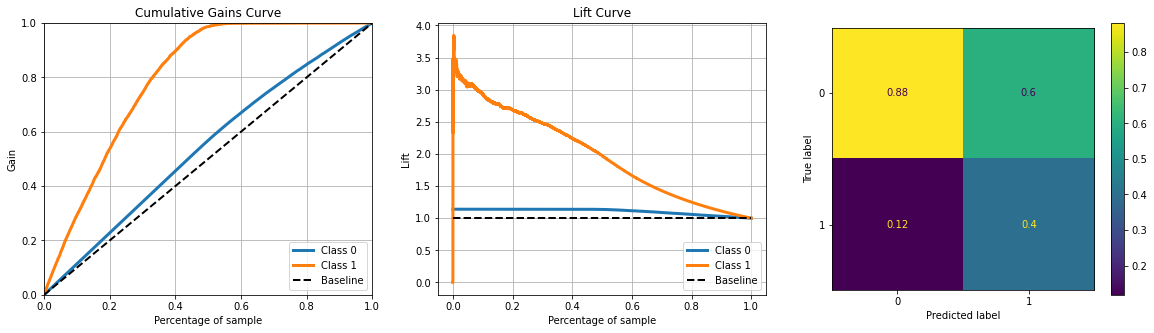

In [262]:
# model definition
xgb_model_final = xgb.XGBClassifier(n_estimators      = best_params['n_estimators'],
                                    eta               = best_params['eta'],
                                    max_depth         = best_params['max_depth'],
                                    subsample         = best_params['subsample'],
                                    colsample_bytree  = best_params['colsample_bytree'],
                                    n_jobs=-1)

# model fit
xgb_model_final.fit(x_training_full[cols_selected],y_training_full)
pickle.dump(xgb_model_final,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\model\\xgb_model.pkl','wb'))

# ==== Model Score 
# model prediction
y_score_xgb = xgb_model_final.predict_proba(X_test)
# performance
xgb_result_rank = ranking_performance('XGBoost', X_test, Y_test_raw, y_score_xgb)

# ==== Model Prediction 
# model prediction
y_pred_xgb = xgb_model_final.predict(X_test)
# performance
xgb_result_class = classification_performance('XGBoost', Y_test_raw, y_pred_xgb)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
g = skplt.metrics.plot_cumulative_gain(Y_test_raw,y_score_xgb,ax=ax[0])
skplt.metrics.plot_lift_curve(Y_test_raw,y_score_xgb,ax=ax[1]);
plot_confusion_matrix(xgb_model_final, X_test,Y_test_raw,normalize='pred',ax=ax[2])  
plt.show() 

# 9.0 Business Result

#### 1. Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

#### 2. Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, se o time de vendas conseguirá contatar fazendo 20.000 ligações?

#### 3. E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

#### 4. Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

In [178]:
results_baseline = pd.DataFrame()

# index
results_baseline['index'] = range(1,len(y_validation)+1)

# real interest
results_baseline['real'] = y_validation.tolist()

# client window
window = 1000
results_baseline['clients_acumulate'] = 0
for i in arange(0,len(y_validation)/window,1).astype(int):
    results_baseline['clients_acumulate'][(window)*i:window*(i+1)] = window*(i+1)

# group by client window
df_baseline = results_baseline[['clients_acumulate','real']].groupby('clients_acumulate').agg(clients = ('real','count'),interest= ('real','sum')).reset_index()

# interest
df_baseline['interest_acumulate'] = df_baseline['interest'].cumsum()

# gross revenue
df_baseline['gross_revenue'] = 40 * df_baseline['interest']
df_baseline['gross_revenue_acumulate'] = df_baseline['gross_revenue'].cumsum()

# cost
df_baseline['cost'] = 4 * df_baseline['clients']
df_baseline['cost_acumulate'] = df_baseline['cost'].cumsum()

# revenue 
df_baseline['revenue'] = df_baseline['gross_revenue'] - df_baseline['cost']
df_baseline['revenue_acumulate'] = df_baseline['revenue'].cumsum()

df_baseline[['clients_acumulate','interest','interest_acumulate','gross_revenue_acumulate','cost_acumulate','revenue_acumulate']]

,clients_acumulate,interest,interest_acumulate,gross_revenue_acumulate,cost_acumulate,revenue_acumulate
0,1000,110,110,4400,4000,400
1,2000,117,227,9080,8000,1080
2,3000,122,349,13960,12000,1960
3,4000,121,470,18800,16000,2800
4,5000,122,592,23680,20000,3680
...,...,...,...,...,...,...
64,65000,127,7917,316680,260000,56680
65,66000,118,8035,321400,264000,57400
66,67000,115,8150,326000,268000,58000
67,68000,115,8265,330600,272000,58600


In [182]:
results_ml = pd.DataFrame()

# index
results_ml['index'] = range(1,len(y_validation)+1)

# score
results_ml['score'] = y_score_xgb[:,1].tolist()

# real interest
results_ml['real'] = y_validation.tolist()

# order dataset
results_ml = results_ml.sort_values('score',ascending=False)

# client window
window = 1000
results_ml['clients_acumulate'] = 0
for i in arange(0,len(y_validation)/window,1).astype(int):
    results_ml['clients_acumulate'][(window)*i:window*(i+1)] = window*(i+1)

# group by client window
df = results_ml[['clients_acumulate','real']].groupby('clients_acumulate').agg(clients = ('real','count'),interest= ('real','sum')).reset_index()

# interest
df['interest_acumulate'] = df['interest'].cumsum()

# gross revenue
df['gross_revenue'] = 40 * df['interest']
df['gross_revenue_acumulate'] = df['gross_revenue'].cumsum()

# cost
df['cost'] = 4 * df['clients']
df['cost_acumulate'] = df['cost'].cumsum()

# revenue 
df['revenue'] = df['gross_revenue'] - df['cost']
df['revenue_acumulate'] = df['revenue'].cumsum()

df[['clients_acumulate','interest','interest_acumulate','gross_revenue_acumulate','cost_acumulate','revenue_acumulate']]

,clients_acumulate,interest,interest_acumulate,gross_revenue_acumulate,cost_acumulate,revenue_acumulate
0,1000,399,399,15960,4000,11960
1,2000,437,836,33440,8000,25440
2,3000,399,1235,49400,12000,37400
3,4000,375,1610,64400,16000,48400
4,5000,333,1943,77720,20000,57720
...,...,...,...,...,...,...
64,65000,0,8339,333560,260000,73560
65,66000,0,8339,333560,264000,69560
66,67000,0,8339,333560,268000,65560
67,68000,1,8340,333600,272000,61600


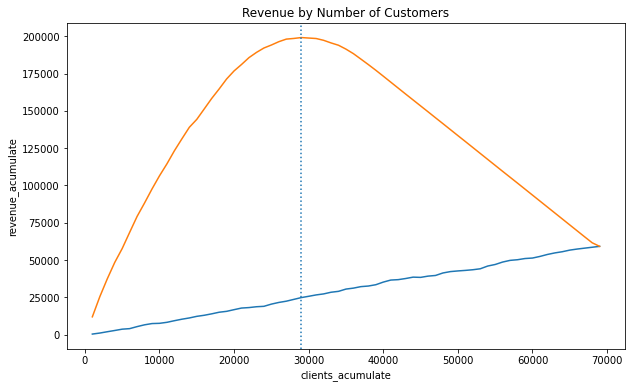

In [184]:
optimal_number_of_clients = df.loc[df['revenue_acumulate'] == max(df['revenue_acumulate']), ['clients_acumulate']].values

plt.figure(figsize=(10,6))
plt.title('Revenue by Number of Customers')
sns.lineplot(x='clients_acumulate',y='revenue_acumulate',data=df_baseline)
sns.lineplot(x='clients_acumulate',y='revenue_acumulate',data=df);
plt.axvline(x = optimal_number_of_clients, linestyle = ':') 

# 10.0 Deployment

In [87]:
class HealthInsurance():
    def __init__(self):
        self.home_path = 'C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\'
        self.annual_premium_scaller      = pickle.load(open(self.path + 'src\\features\\annual_premium_scaller.pkl'))
        self.age_scaler                  = pickle.load(open(self.path + 'src\\features\\age_scaler.pkl'))
        self.vintage_scaler              = pickle.load(open(self.path + 'src\\features\\vintage_scaler.pkl'))
        self.gender_scaler               = pickle.load(open(self.path + 'src\\features\\gender_scaler.pkl'))
        self.region_code_scaler          = pickle.load(open(self.path + 'src\\features\\region_code_scaler.pkl'))
        self.policy_sales_channel_scaler = pickle.load(open(self.path + 'src\\features\\policy_sales_channel_scaler.pkl'))             
    
    def data_cleaning(self, df1):

        # region_code
        df1['region_code'] = df1['region_code'].astype('int64')

        # policy_sales_channel 
        df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

        return df1

    def feature_engineering(self, df2):

        # vericle_age
        df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'bellow_1_year' if x == '< 1 Year' else 
                                                             'between_1_2_year' if x == '1-2 Year' else 
                                                             'over_2_years')
        return df2
    
    
    def data_preparation(self, df5):

        ss = pp.StandardScaler()

        ## annual_premium
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        ## 5.3 Rescaling

        ## age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        ## vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        ## 5.4 Encoder
        ### 5.4.1 One Hot Enconding

        ## vehicle_age
        df5 = pd.get_dummies(df5, prefix='vehicle_age',columns=['vehicle_age'])

        ### 5.4.2 Target Enconding

        # gender 
        df5.loc[:,'gender'] = df5['gender'].map(self.gender_scaler)

        # region_code 
        df5.loc[:,'region_code'] = df5['region_code'].map(self.region_code_scaler)

        # vehicle damage
        df5.loc[:,'vehicle_damage'] = df5['vehicle_damage'].map(self.vehicle_damage_scaler)

        ### 5.4.3 Frequency Enconding

        ## policy_sales_channel 
        df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(self.policy_sales_channel_scaler)

        cols_selected = [
                'vintage',
                'annual_premium',
                'age',
                'region_code',
                'vehicle_damage',
                'policy_sales_channel',
                'previously_insured']
        
        return df5[cols_selected]

    def get_predict(self, model, original_data, test_data):
        
        # model prediction
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records', date_format='iso')
        

## 10.2. API Handler

In [88]:
# import pickle
# import pandas as pd
# from flask import Flask, request, Response
# from healthinsurance import HealthInsurance
# import xgboost as xgb

# path = 'C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\'
# model = pickle.load(open(path + 'src//model/xgb_model.pkl','rb'))

# app = Flask(__name__)

# @app.route('/predict',methods=['POST'])
# def health_insurance_predict():
#     test_json = request.get_json()
    
#     if test_json:
#         # there is data 
#         if isinstance(test_json, dict): # unique example
#             test_raw = pd.DataFrame(test_json,index=[0])
#         else: # multiple examples
#             test_raw = pd.DataFrame(test_json,columns = test_json[0].keys())
            
#         # Instantiate HeathInsurance class
#         pipeline = HealthInsurance()

#         # data cleaning
#         df1 = pipeline.data_cleaning(test_raw)

#         # feature engineering
#         df2 = pipeline.feature_engineering(df1)

#         # data preparation
#         df3 = pipeline.data_preparation(df2)

#         # prediction
#         df_response = pipeline.get_predict(model,test_raw,df3)
    
#         return df_response
#     else:
#         return Response('{Request is empty}',status=200, mimetype='application/json')

# if __name__ == '__main__':
#     app.run('0.0.0.0')

## 10.3 API Tester

In [89]:
X_test.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
211126,0.508651,0.339728,0.061538,0.071137,0.005282,0.027876,1
243656,0.373702,0.068492,0.600000,0.103746,0.237668,0.209112,0
233989,0.882353,0.289525,0.092308,0.129081,0.237668,0.194258,0
321291,0.861592,-1.624175,0.769231,0.088136,0.237668,0.209112,0
89078,0.871972,0.095046,0.507692,0.142359,0.005282,0.209112,1


In [90]:
# loading test dataset
df_test = X_test_raw
df_test['response'] = Y_test_raw

data = json.dumps(df_test.to_dict(orient='records'))

In [91]:
# url = 'http://192.168.18.4:5000/predict'

url = 'https://insurance-crosssell-app.herokuapp.com/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url,data=data,headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [92]:
pd.DataFrame(r.json(),columns= r.json()[0].keys())

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,prediction
0,161470,Male,-0.306746,30,156,1,over_2_years,No,1,-1.774295,-0.032842,0,0.000863
1,41353,Male,-0.298462,46,26,1,over_2_years,Yes,0,-1.774311,-0.033309,0,0.027408
2,343813,Male,-0.306272,3,124,1,over_2_years,Yes,0,-1.774298,-0.031549,0,0.039039
3,281070,Female,-0.295858,13,26,1,over_2_years,Yes,0,-1.774409,-0.031621,0,0.036657
4,329965,Male,-0.299882,23,26,1,over_2_years,No,1,-1.774309,-0.031585,0,0.000264
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38106,315741,Female,-0.306036,41,152,1,over_2_years,No,1,-1.774321,-0.032806,0,0.000191
38107,378244,Female,-0.306746,6,152,1,over_2_years,No,1,-1.774298,-0.033237,0,0.000180
38108,359017,Female,-0.299645,28,124,1,over_2_years,No,0,-1.774274,-0.034351,0,0.048353
38109,15870,Male,-0.304852,28,154,1,over_2_years,Yes,0,-1.774307,-0.034399,0,0.168059
